<div style="background-color: white; padding: 20px; border-radius: 8px; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.1); color: #333; font-family: Arial, sans-serif;">
    <h3 style="font-size: 22px; font-weight: bold; color: #20639B; margin-bottom: 10px;">1. Import Libraries </h3>
    
</div>


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

#%pip install scikit-learn
# !pip install open-cv
# !pip install torch
# !pip install fastai

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import cv2
import sklearn
import torch
from PIL import Image
from pathlib import Path
from fastai.vision.all import *
from fastai.callback import *
from fastai.metrics import error_rate
from fastai.callback.tracker import EarlyStoppingCallback
from fastai.vision.all import get_image_files
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings ('ignore')

<div style="background-color: white; padding: 20px; border-radius: 8px; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.1); color: #333; font-family: Arial, sans-serif;">
    <h3 style="font-size: 22px; font-weight: bold; color: #20639B; margin-bottom: 10px;">2. Load Data </h3>
    
</div>


In [3]:
# path = Path('/kaggle/input/ai-generated-images-vs-real-images')
path = Path('/content/drive/MyDrive/Project/ai-vs-real-images')

In [4]:
path.ls()

(#3) [Path('/content/drive/MyDrive/Project/ai-vs-real-images/AI-Generated'),Path('/content/drive/MyDrive/Project/ai-vs-real-images/.ipynb_checkpoints'),Path('/content/drive/MyDrive/Project/ai-vs-real-images/Captured-Image')]

In [5]:
dls = ImageDataLoaders.from_folder(path, train='train', valid_pct=0.3,
                                          item_tfms=Resize(460),
                                          batch_tfms=[*aug_transforms(size=224), Normalize.from_stats(*imagenet_stats)])

In [6]:
len(dls.train_ds)

730

In [7]:
len(dls.valid_ds)

312

In [8]:
print(dls.vocab)

['AI-Generated', 'Captured-Image']


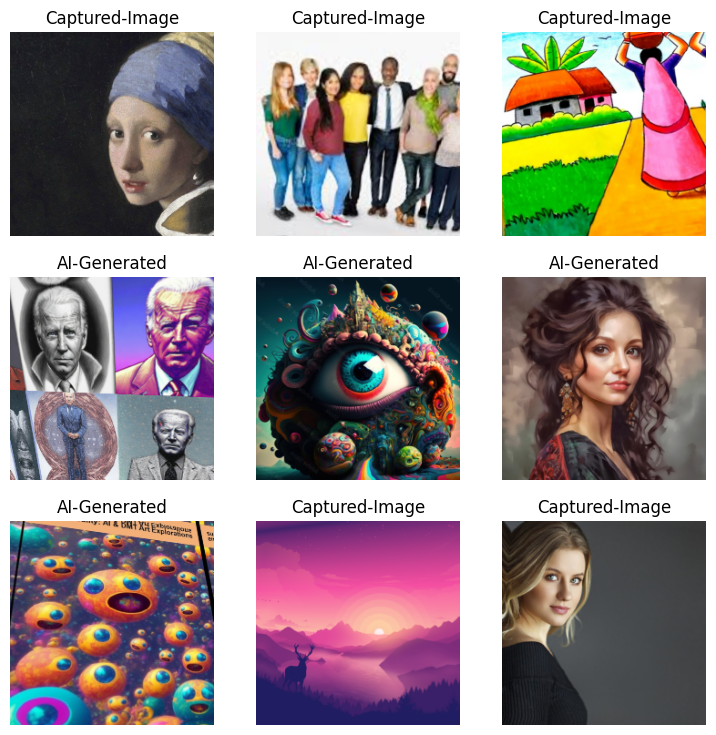

In [9]:
dls.show_batch()

In [10]:
# we used cnn technique and model is resnet34
learn = vision_learner(dls, resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 47.8MB/s]


In [11]:
learn.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

<div style="background-color: white; padding: 20px; border-radius: 8px; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.1); color: #333; font-family: Arial, sans-serif;">
    <h3 style="font-size: 22px; font-weight: bold; color: #20639B; margin-bottom: 10px;">3. Training Data </h3>
    
</div>


In [12]:
learn.model_dir='/content/drive/MyDrive/Project/Result'

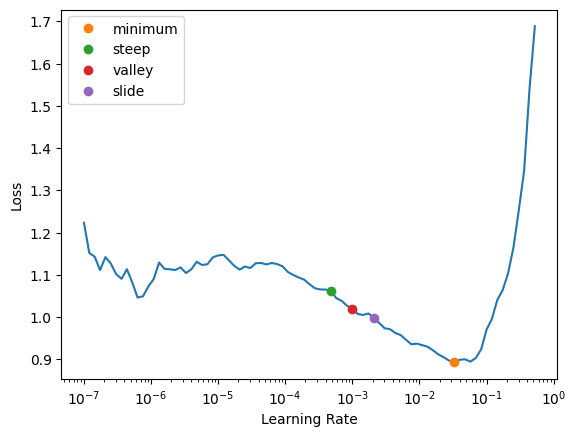

In [13]:
# learning rate
suggest_funcs = (minimum, steep, valley, slide)

lrs = learn.lr_find(suggest_funcs=suggest_funcs)

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

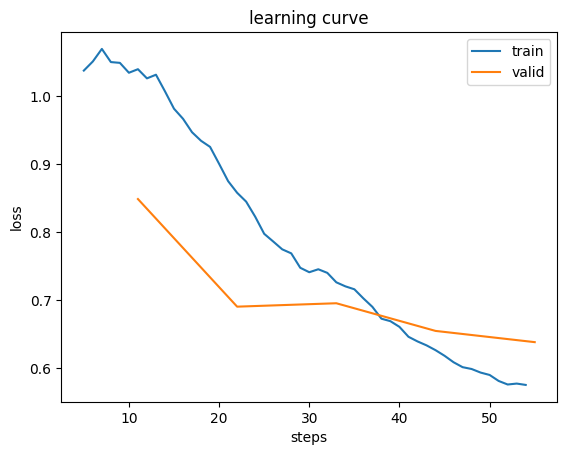

In [14]:
learn.fit_one_cycle(5, lr_max=slice(lrs.valley, lrs.slide))
learn.recorder.plot_loss()

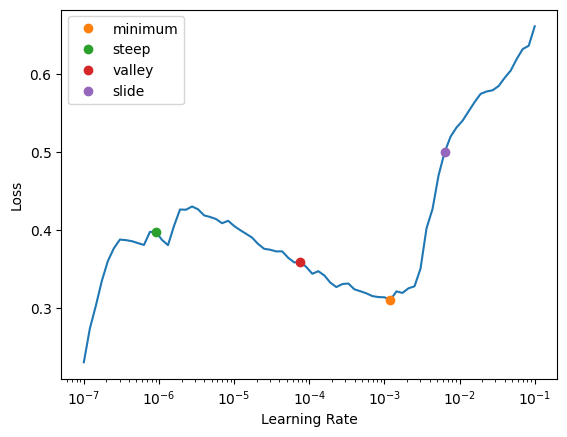

In [15]:
learn.unfreeze()
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

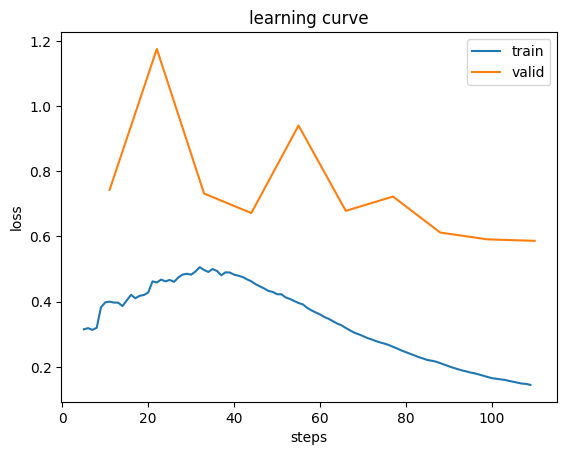

In [16]:
learn.fit_one_cycle(10, lr_max=slice(lrs.valley, lrs.slide))
learn.recorder.plot_loss()

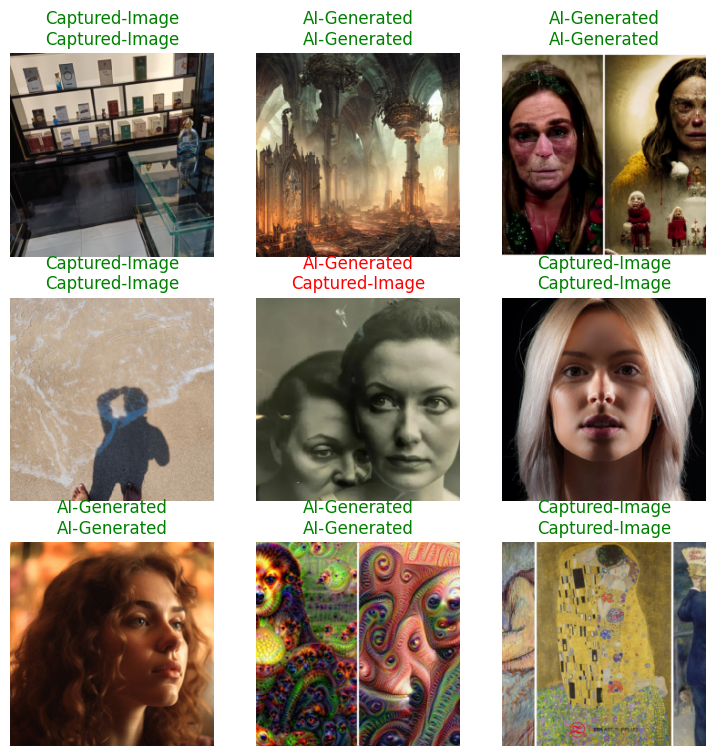

In [17]:
learn.show_results()

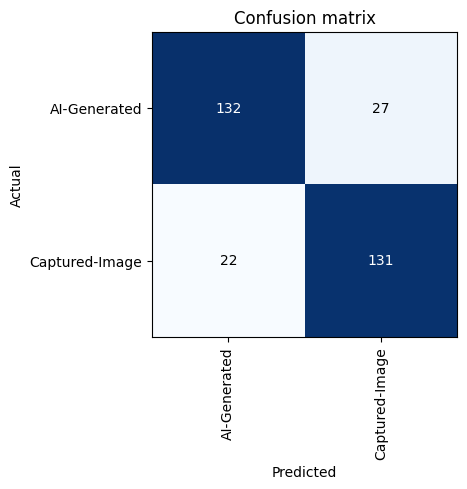

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

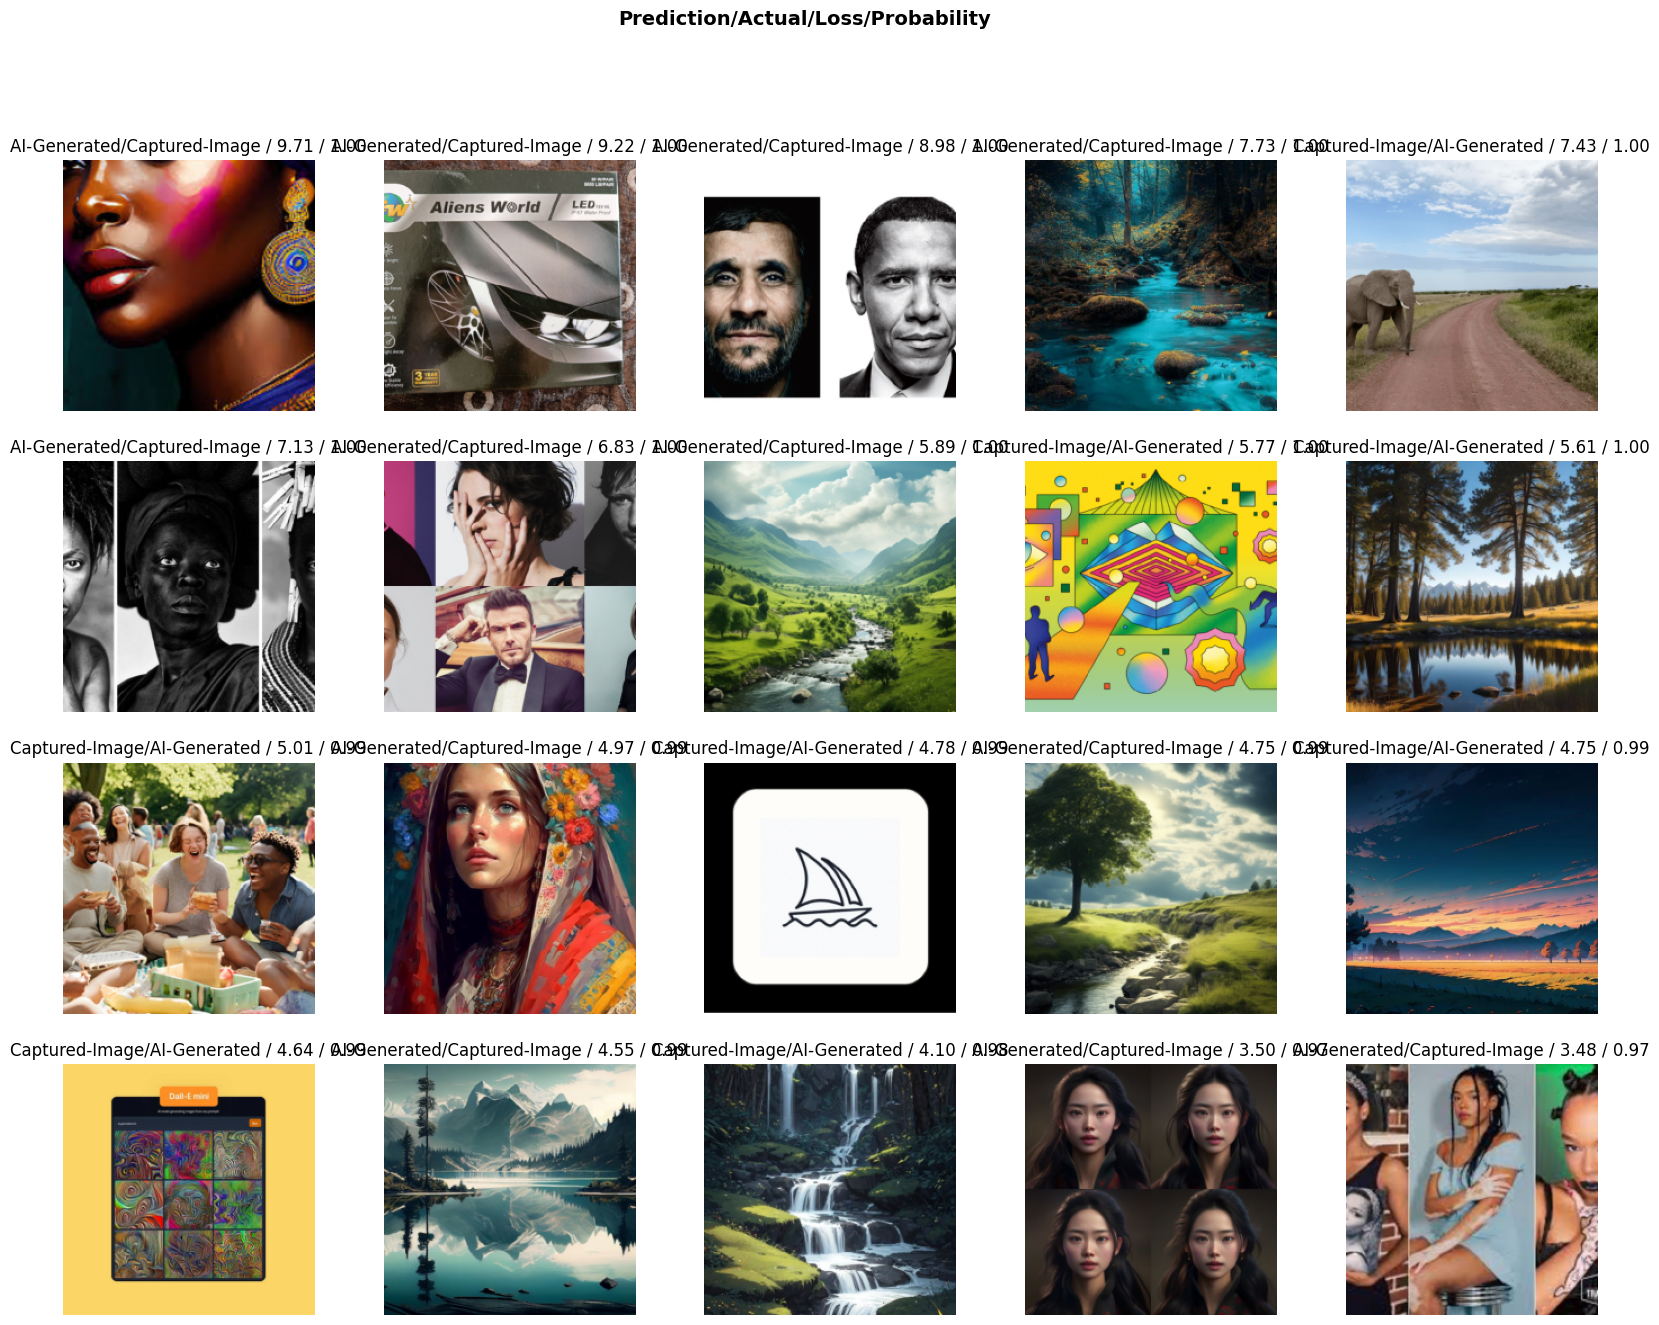

In [19]:
interp.plot_top_losses(20,figsize = (20,15))

In [20]:
preds, targets = learn.get_preds()

class_report = classification_report(targets, torch.argmax(preds, dim=1), target_names=dls.vocab)
print(class_report)

                precision    recall  f1-score   support

  AI-Generated       0.86      0.83      0.84       159
Captured-Image       0.83      0.86      0.84       153

      accuracy                           0.84       312
     macro avg       0.84      0.84      0.84       312
  weighted avg       0.84      0.84      0.84       312



In [50]:
import pickle

with open("/content/drive/MyDrive/Project/mymodel.pkl","wb") as f:
  pickle.dump(learn, f)

In [22]:
# img = learn.dls.train_ds[11][0]
# learn.predict(img)

('Captured-Image', tensor(1), tensor([7.2723e-05, 9.9993e-01]))

Predicted class: AI-Generated
Prediction index: 0
Model output probabilities: tensor([9.9987e-01, 1.2881e-04])


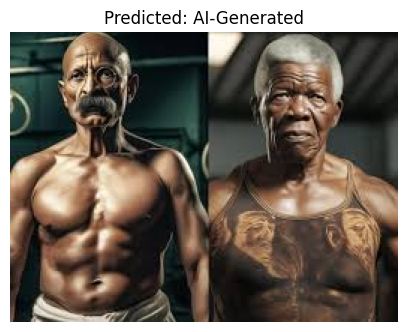

In [68]:
def test_external_image(img_path):
    img = PILImage.create(img_path)
    img.show()
    pred_class, pred_idx, outputs = learn.predict(img)
    print(f"Predicted class: {pred_class}")
    print(f"Prediction index: {pred_idx}")
    print(f"Model output probabilities: {outputs}")

    plt.title(f"Predicted: {pred_class}")
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Example usage:
test_image_path = '/content/drive/MyDrive/Project/predict/download (1).jpeg'
test_external_image(test_image_path)

In [52]:
# import os

# file_path = "/content/drive/MyDrive/Project/mymodel.pkl"
# if os.path.getsize(file_path) > 0:
#     with open(file_path, "rb") as f:
#         mmm2 = pickle.load(f)
# else:
#     print("File is empty")

In [4]:
# import pickle
# with open("/content/drive/MyDrive/Project/msf.pkl","rb") as f:
#   mmm = pickle.load(f)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

Predicted class: Captured-Image
Prediction index: 1
Model output probabilities: tensor([0.0054, 0.9946])


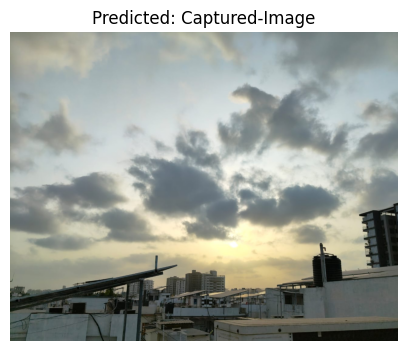

In [59]:
def test_external_image(img_path):
    img = PILImage.create(img_path)
    img.show()
    pred_class, pred_idx, outputs = mmm.predict(img)
    print(f"Predicted class: {pred_class}")
    print(f"Prediction index: {pred_idx}")
    print(f"Model output probabilities: {outputs}")

    plt.title(f"Predicted: {pred_class}")
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Example usage:
test_image_path = '/content/drive/MyDrive/Project/predict/img6.jpg'
test_external_image(test_image_path)